## Introduction:


Ce projet a pour but de créer un outil permettant de modéliser le processus de dégradation d'un moteur industriel ainsi que d'estimer l'évolution de son indicateur de santé. Pour cela, nous avons à disposition un fichier de données sous format exel, recensant les mesures de dix caractéristiques physiques de ce moteur, mesures effectuées à intervalle régulier dans le temps (90850 points). Nous nous servirons de ces caractéristiques pour construire notre modèle.

#### 1.Explication des données

Les différentes caractéristiques physiques du moteur qui nous sont fournies sont celles-ci :
* Deg: indicateur représentant le mode dégradé (Deg=1) ou le mode non-dégradé (Deg=0)
* Mo: indicateur représentant le mode de fonctionnement
* GO en l/h, consommation de carburant
* CO en %, le couple moteur 
* CR en %, la position du cran moteur ( ≈ accélérateur)
* P1 en bars, la pression de la suralimentation
* PW en %, la puissance moteur 
* T3p en °C, la température en sortie compresseur
* T1 en °C, la température d’admission 
* Ready: indicateur représentant l’état d’arrêt (0) ou l’état opératoire (1)


#### 2.Bilbliothèques utilisées

Les outils que nous utilisons pour analyser les données et construire notre modèle sont issus des librairies suivantes de Python:

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.svm import SVR, LinearSVR
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
path = "DataPHM.xlsx"

#### 3.Etapes de l'implémentation 

Afin de répondre à l'objectif fixé nous allons diviser notre travail en plusieurs parties:
1. Le nettoyage des données
2. La détermination de l'indicateur de santé et des facteurs d'influence
3. La détermination de la période dégradée et non dégradée
4. La détermination du modèle en mode non dégradé
5. L'apprentissage et la prédiction en mode non dégradé
6. La prédiction en mode dégradé et le calcul du résidu

## I- Présentation et explication des fonctions


Dans cette partie nous expliquerons l'implémentation des différentes fonctions qui nous permettent d'analyser les données, trouver l'indicateur de santé ainsi que les variables de sorties, et finalement créer un modèle de prédiction pour l'indicateur de santé (en mode non dégradé) et le résidu (en mode dégradé).

#### 1. Nettoyage des données

Nous avons commencé par récupérer toutes les variables utiles pour notre étude c'est à dire les variables explicatives et sorties possibles pour notre modèle en considérant que le moteur est à l'état ready=1.

In [7]:
def data_cleared():
    df = pd.read_excel(path)
    n = df.shape[0]
    #nettoyage des données
    M = []
    j = 0 
    for i in range(0,n):
        
        if int(df.iloc[i][9]) == 1:
            M.append(list(df.iloc[i]))
            j += 1

    Sensor_GO = []
    Sensor_CO = []
    Sensor_CR = []
    Sensor_P1 = []
    Sensor_PW = []
    Sensor_T3P = []
    Sensor_T1 = []
    Mode = []

    for i in M:
        Mode.append(i[1])
        Sensor_GO.append(i[2])
        Sensor_CO.append(i[3])
        Sensor_CR.append(i[4])
        Sensor_P1.append(i[5])
        Sensor_PW.append(i[6])
        Sensor_T3P.append(i[7])
        Sensor_T1.append(i[8])
    return Mode,Sensor_GO,Sensor_CR,Sensor_CO,Sensor_P1,Sensor_PW,Sensor_T3P,Sensor_T1,M


#### 2. Détermination de l'indicateur de santé et des facteurs d'influences


Nous visualisons toutes les sorties potentielles pour déterminer notre indicateur de santé qui informe sur la dégradation du moteur en traçant les courbes montrant leur évolution au cours du temps. Ensuite en fonction de ces courbes, on détermine l'indicateur de santé et on affiche ensuite la matrice de corrélation de l'indicateur de santé et des facteurs d'influence possibles pour indiquer les variables explicatives les plus corrélées à l'indicateur de santé choisit. 



In [8]:
def data_visualisation(Sensor_GO,Sensor_P1,Sensor_PW,Sensor_T3P,Sensor_CR,Sensor_T1,Mode,Sensor_CO):

    """Permet la visualisation des données """
    fig,axs = plt.subplots(4,2,figsize=(10,15))
    
    axs[0,0].plot(Sensor_GO)
    axs[0,0].set_xlabel('Temps')
    axs[0,0].set_ylabel('GO')
    axs[0,0].set_title('Sensor GO')
    

    
    axs[0,1].plot(Sensor_P1)
    axs[0,1].set_xlabel('Temps')
    axs[0,1].set_ylabel('P1')
    axs[0,1].set_title('Sensor P1')

    

    
    axs[1,0].plot(Sensor_PW)
    axs[1,0].set_xlabel('Temps')
    axs[1,0].set_ylabel('PW')
    axs[1,0].set_title('Sensor PW')
    

    
    axs[1,1].plot(Sensor_T3P)
    axs[1,1].set_xlabel('Temps')
    axs[1,1].set_ylabel('T3P')
    axs[1,1].set_title('Sensor T3P')

    axs[2,0].plot(Sensor_CR)
    axs[2,0].set_xlabel('Temps')
    axs[2,0].set_ylabel('CR')
    axs[2,0].set_title('Sensor CR')

    axs[2,1].plot(Sensor_T1)
    axs[2,1].set_xlabel('Temps')
    axs[2,1].set_ylabel('T1')
    axs[2,1].set_title('Sensor T1')
    

    axs[3,0].plot(Sensor_CO)
    axs[3,0].set_xlabel('Temps')
    axs[3,0].set_ylabel('CO')
    axs[3,0].set_title('Sensor CO')

    axs[3,1].plot(Mode)
    axs[3,1].set_xlabel('Temps')
    axs[3,1].set_ylabel('Mode')
    axs[3,1].set_title('Mode')


    plt.tight_layout()
    plt.show()

In [9]:
import seaborn as sns
def corr_matrix(ind_sante,var1,var2,var3,var4,var5,var6,var7,stris):
    
    data = pd.DataFrame({stris:ind_sante,'Mode':var1,'CO':var2,'CR':var3,'T1':var4,'GO':var5,'P1':var6,'PW':var7})
    corr_matrix = data.corr()
    print(corr_matrix)

def plotpair(ind_sante,var1,var2,var3,var4,var5,var6,var7):
    data = pd.DataFrame({'T3P':ind_sante,'Mode':var1,'CO':var2,'CR':var3,'T1':var4,'GO':var5,'P1':var6,'PW':var7})
    sns.pairplot(data)
    plt.show()


#### 3. Détermination de la période dégradée et non dégradée
Cette fonction a pour objectif de déterminer la période dégradée et non dégradée. En nous appuyant sur la caractéristique Deg qui nous renseigne sur le mode dégradé ou non d'un point de mesure, cette fonction parcours l'ensemble des points de mesures, lorsqu'il trouve un point dont la valeur de Deg vaut 1, il compte le nombre de points suivants dont la valeur de Deg vaut également 1.


In [10]:


def give_degradation(M):

    """donne les différentes périodes des deux modes de dégradation"""
    T1 = 0
    while M[T1][0] == 0:
        T1+= 1

    Tfin=T1+1


    while M[Tfin][0]==1 and Tfin<len(M)-1:
        Tfin+=1


    return T1,Tfin


#### 4. Détermination du modèle en mode non dégradé

##### 4.1 Modèle SVR

Le modèle SVR (support vector regression) cherche l'hyperplan qui s'ajuste au mieux aux données dans un espace multidimensionnel (si plus de deux variables explicatives) ou dans le plan (si une variable explicative) tout en minimisant l'erreur de prédiction. 
Nous entrainons deux types de modèle SVR  : linéaire et non linéaire.
Avant tout, nous cherchons la combinaison d'hyperparamètres qui maximise le coefficient de détermination pour chaque modèle sur les données de validation et ensuite nous évaluons les performances du modèle choisi sur les données de test. Pour cela nous utilisons les fonction grid-search et randomsearch de la bibliothèque sklearn.

Nous commençons par chercher les combinaisons d'hyperparamètres optimaux pour un modèle linéaire et un modèle non linéaire de SVR et nous comparons les deux coefficients de détermination sur les données de test.

In [25]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.svm import SVR, LinearSVR
from proginit import X_train, Y_train,X_test,Y_test

param_grid = {'C': [0.1, 1, 10], 'epsilon': [0.1, 0.01, 0.001]}

model = LinearSVR(dual="auto")
def withgridsearch(model,param_grid):
    print("with gridsearch")
    grid = GridSearchCV(model,param_grid,cv=5,scoring='r2')
    grid.fit(X_train,Y_train)
    print(grid.best_params_)
    return grid

    
def withrandomsearch(model,param_grid):
    print("with randomsearch")
    grid1 = RandomizedSearchCV(model,param_grid,scoring='r2',n_iter=10)
    grid1.fit(X_train,Y_train)
    print(grid1.best_params_)
    return grid1

grid = withgridsearch(model,param_grid)
best_svm = LinearSVR(C=grid.best_params_['C'], epsilon=grid.best_params_['epsilon'],dual="auto")
best_svm.fit(X_train,Y_train)
Y_pred1 = best_svm.predict(X_test)
print(f"coefficient de détermination meilleur modèle gridsearch: {r2_score(Y_test, Y_pred1)}")


with gridsearch
{'C': 10, 'epsilon': 0.001}
coefficient de détermination meilleur modèle gridsearch: 0.47650017562057634


Ainsi en nous basant sur ces résultats, le meilleur modèle linéaire de SVR a pour paramètres optimaux: 
* C=10, epsilon=0.001 et un coefficient de détermination de 0.4765234536632649
Nous utiliserons ce modèle linéaire de SVR pour le comparer au meilleur modèle non linéaire de SVR fans le cadre de nos données. 




Maintenant, nous allons chercher le meilleur modèle non linéaire de SVR pour nos données. Pour cela nous testons deux noyaux : gaussiens(rbf) et polynomial.

* Le noyau gaussien (rbf) est le plus adapté selon la documentation aux problèmes de régression non linéaire. Il est caractérisé par un paramètre gamma, qui permet de régler l'ajustement du modèle aux données d'entrainement.

* Le noyau polynomial utilise une fonction polynomiale pour projeter les données d'entrée dans un espace de dimension supérieure. Cette fois-ci, plus le degré du polynôme est élevé et plus le modèle s'adaptera aux données d'entrainement.

Le but est de trouver des hyperparamètres qui permettent d'augmenter la précision du modèle (le coefficient de détermination)  tout en évitant l'over-fitting.

In [15]:
param_gridgaussien = {'kernel':['rbf'],'C': [0.1, 1, 10,100], 'gamma': [0.1,0.01,0.001,0.0001]}
param_gridpoly =  {'kernel':['poly'],'degree':[2,3,4,5,6,7,8]}
modelnl = SVR(kernel='rbf')
print("pour noyau gaussien")
gridgs1 = withgridsearch(modelnl,param_gridgaussien)
best_svr1 = SVR(kernel='rbf',C=gridgs1.best_params_['C'], gamma=gridgs1.best_params_['gamma'])
best_svr1.fit(X_train,Y_train)
Y_pred1 = best_svr1.predict(X_test)
print(f"coefficient de détermination meilleur modèle gridsearch: {r2_score(Y_test, Y_pred1)}")
gridrs1 = withrandomsearch(modelnl,param_gridgaussien)
best_svr2 = SVR(kernel='rbf',C=gridrs1.best_params_['C'], gamma=gridrs1.best_params_['gamma'])
best_svr2.fit(X_train,Y_train)
Y_pred2 = best_svr2.predict(X_test)
print(f"coefficient de détermination meilleur modèle gridsearch: {r2_score(Y_test, Y_pred2)}")
print("pour noyau polynomial")
gridgs2 = withgridsearch(modelnl,param_gridpoly)
best_svr3 = SVR(kernel='poly',C=gridgs2.best_params_['degree'])
best_svr3.fit(X_train,Y_train)
Y_pred3 = best_svr3.predict(X_test)
print(f"coefficient de détermination meilleur modèle gridsearch: {r2_score(Y_test, Y_pred3)}")



pour noyau gaussien
with gridsearch
{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
coefficient de détermination meilleur modèle gridsearch: 0.5694679784110692
with randomsearch
{'kernel': 'rbf', 'gamma': 0.1, 'C': 100}
coefficient de détermination meilleur modèle gridsearch: 0.5694679784110692
pour noyau polynomial
with gridsearch
{'degree': 3, 'kernel': 'poly'}
coefficient de détermination meilleur modèle gridsearch: -13.32760338274343


Nous constatons que la meilleure combinaison d'hyperparamètres du SVR pour le kernel polynomial nous donne un coefficient de détermination négatif, il n'est donc pas adapté pour notre jeu de données. Par contre nous obtenons un meilleur coefficient de détermination pour la combinaison optimale d'hyperparamètres du SVR pour le noyau gaussien, nous utiliserons donc ce modèle gaussien comme modèle non linéaire pour le comparer aux autres modèles. 

In [ ]:

def train_first_model(X_train,Y_train,X_test,Y_test):
    """Apprentissage avec modèle de regression linéaire"""
    #modèle optimal
    model = LinearSVR(C=100,epsilon=0.001)
    #utiliser gridsearch
    model.fit(X_train,Y_train)
    Y_pred = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_pred)

    print("modèle linéaire:")
    print(f"constante : {model.intercept_}")
    print(f"coefs : {model.coef_}")
    print(f"coefficient de détermination : {r2_score(Y_test, Y_pred)}")
    print(f"rmse : {mse}")
    return model,r2_score(Y_test, Y_pred)

In [ ]:
def train_second_model(X_train,Y_train,X_test,Y_test):

    """Apprentissage avec modèle de régression non linéaire """
    #modèle optimal
    model = SVR(kernel='rbf', C=100, gamma=0.1)


    model.fit(X_train,Y_train)
    Y_pred = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_pred)
    print("modèle non linéaire:")
    print(f"rmse : {mse}")
    print(f"coefficient de détermination : {r2_score(Y_test, Y_pred)}")

    return model,r2_score(Y_test, Y_pred)



#### 4.2 Autres modèles testés

Afin d'améliorer le modèle de régression nous avons cherché à utiliser d'autres modèles de prédiction non linéaires de la bibliothèque scikit-learn comme l'arbre de régression (DecisionTreeRegressor) et un réseau de neurones (MLPRegressor) et nous avons comme dans la partie précédente utilisé les hypermaramètres les plus optimaux pour maximiser le coefficient de détermination.
Nous avons au préalable testé les combinaisons d'hyperparamètres pour le MLP en jouant sur le nombre de neurones par couches et le nombre de couches mais nous avions des coefficients de détermination négatifs (sauf pour les cas d'une couche à 2,3 neurones).
Nous avons donc gardé une couche de 3 neurones car elle donnait le meilleur coefficient de détermination.


Nous allons à présent nous focaliser sur la recherche d'hyperparamètres optimaux pour l'arbre de régression.

In [ ]:
params = {
    'max_depth': [50,100,150,200],
    'min_samples_split': [10, 20, 30,40],
    'min_samples_leaf': [3, 6,8, 10],
}
modelabr = DecisionTreeRegressor(criterion='squared_error', random_state=42)
gridabg = withgridsearch(modelabr,params)
Dtr = DecisionTreeRegressor(criterion='squared_error', random_state=42,max_depth=gridabg.best_params_['max_depth'],min_samples_split=gridabg.best_params_['min_samples_split'],min_samples_leaf=gridabr.best_params_['min_samples_leaf'])
Dtr.fit(X_train,Y_train)
Y_pred5 = Dtr.predict(X_test)
print(f"coefficient de détermination meilleur modèle randomsearch: {r2_score(Y_test, Y_pred5)}")

gridabr = withrandomsearch(modelabr,params)
Dtr = DecisionTreeRegressor(criterion='squared_error', random_state=42,max_depth=gridabr.best_params_['max_depth'],min_samples_split=gridabr.best_params_['min_samples_split'],min_samples_leaf=gridabr.best_params_['min_samples_leaf'])
Dtr.fit(X_train,Y_train)
Y_pred6 = Dtr.predict(X_test)
print(f"coefficient de détermination meilleur modèle randomsearch: {r2_score(Y_test, Y_pred6)}")

with gridsearch
{'max_depth': 50, 'min_samples_leaf': 3, 'min_samples_split': 10}
coefficient de détermination meilleur modèle randomsearch: 0.7010689487693327
with randomsearch
{'min_samples_split': 10, 'min_samples_leaf': 6, 'max_depth': 100}
coefficient de détermination meilleur modèle randomsearch: 0.7112843595102538


La combinaison optimale d'hyperparamètres pour l'arbre de régression nous donne un bon coefficient de détermination de 0.71, nous l'utiliserons donc comme 4ème modèle   pour le comparer aux autres modèles aussi optimisés.

In [ ]:
def train_third_model(X_train,Y_train,X_test,Y_test):

    print("Apprentissage avec modèle de perceptron multicouche pour régression")



    model = MLPRegressor(hidden_layer_sizes=(3,), random_state=42,activation='relu',solver='adam',max_iter=1000)
    model.fit(X_train,Y_train)
    Y_pred = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_pred)
    print(f"rmse : {mse}")
    print(f"coefficient de détermination : {r2_score(Y_test, Y_pred)}")
    
    return model,r2_score(Y_test, Y_pred)

def train_forth_model(X_train,Y_train,X_test,Y_test):

    print("Apprentissage avec arbre de décision")
    model=DecisionTreeRegressor(criterion='squared_error', random_state=42,min_samples_split=10, min_samples_leaf= 6, max_depth=100)
    model.fit(X_train,Y_train)
    Y_pred = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_pred)
    print(f"rmse : {mse}")
    print(f"coefficient de détermination : {r2_score(Y_test, Y_pred)}")

    return model,r2_score(Y_test, Y_pred)

#### 5. Apprentissage et prédiction en mode non dégradé

Nous cherchons parmi les 4 modèles testés celui qui maximise le r2_score (coefficient de détermination) lorsque nous effectuons la prédiction sur les données de l'intervalle [70%T1 ,T1] du mode non dégradé.
Nous conserverons ainsi le meilleur modèle pour la partie suivante.

In [ ]:

def best_model(L):
    max_r2 = 0
    model = L[0][0]
    for i in range(len(L)):
        if L[i][1] > max_r2:
            max_r2 = L[i][1]
            model = L[i][0]
    return model

def test_without_degradation(Sensor_T3P,Mode,Sensor_CO,T1,Tfin,scaler):

    print("effectue la prediction en mode non dégradé")

    lim = 70*T1//100
    features_train = []
    features_test = []
    features_train.append(Mode[:lim+1])
    features_train.append(Sensor_CO[:lim+1])

    features_test.append(Mode[lim+1:T1])
    features_test.append(Sensor_CO[lim+1:T1])

    features_train = np.array(features_train).T
    
    features_test = np.array(features_test).T
    
    scaler = scaler
    Y = np.array(Sensor_T3P[:lim+1])
    Y_test = np.array(Sensor_T3P[lim+1:T1])
    X = scaler.fit_transform(features_train)
    X_test = scaler.fit_transform(features_test)
    X_train,Xv,Y_train,Yv = train_test_split(X,Y,test_size=0.1,random_state=42)

    #train_first_model(X_train,Y_train,X_test,Y_test)
    model1,r2_1=train_first_model(X_train,Y_train,X_test,Y_test)
    model2,r2_2=train_second_model(X_train,Y_train,X_test,Y_test)
    model3,r2_3=train_third_model(X_train,Y_train,X_test,Y_test)
    model4,r2_4=train_forth_model(X_train,Y_train,X_test,Y_test)
    L = []
    L.append((model1,r2_1))
    L.append((model2,r2_2))
    L.append((model3,r2_3))
    L.append((model4,r2_4))

    return best_model(L)



#### 6. Prédiction en mode dégradé et calcul du résidu

L'objectif en mode dégradé est ici de calculer le résidu qui nous permettrait hypothétiquement de trouver la durée de vie résidulle du moteur.
Pour cela nous utilisons le modèle que nous avons utilisé pour prédire l'indicateur de performance en période non dégradé, ensuite, nous calculons la différence entre les valeurs réelles de l'indicateur de santé en mode dégradé et les valeurs prédites par le meilleur modèle en mode non dégradé, sur les variables explicatives en mode dégradé.

In [ ]:
def test_with_degradation(Sensor_T3P,Mode,Sensor_CO,T1,Tfin,model,scaler):

    """effectue la prédiction en mode dégradé"""
    
    lim=T1+70*(Tfin-T1)//100


    features_train = []
    features_test = []
    features_train.append(Mode[T1:lim+1])
    features_train.append(Sensor_CO[T1:lim+1])
    
    features_test.append(Mode[lim+1:Tfin])
    features_test.append(Sensor_CO[lim+1:Tfin])
 
    features_train = np.array(features_train).T
    
    features_test = np.array(features_test).T
   
    scaler = scaler
    Y = np.array(Sensor_T3P[T1:lim+1])
    Y_test = np.array(Sensor_T3P[lim+1:Tfin])
    X = scaler.fit_transform(features_train)
    X_test = scaler.fit_transform(features_test)
  

    T3P_pred = model.predict(X)
    Residu = Y - T3P_pred
    temps = [i for i in range(Residu.shape[0])]

    return Residu


## II- Résultats et interpretations

#### 1. Nettoyage des données


In [17]:
Mode,Sensor_GO,Sensor_CR,Sensor_CO,Sensor_P1,Sensor_PW,Sensor_T3P,Sensor_T1,M=data_cleared()

#### 2. Détermination de l'indicateur de santé et des facteurs d'influence

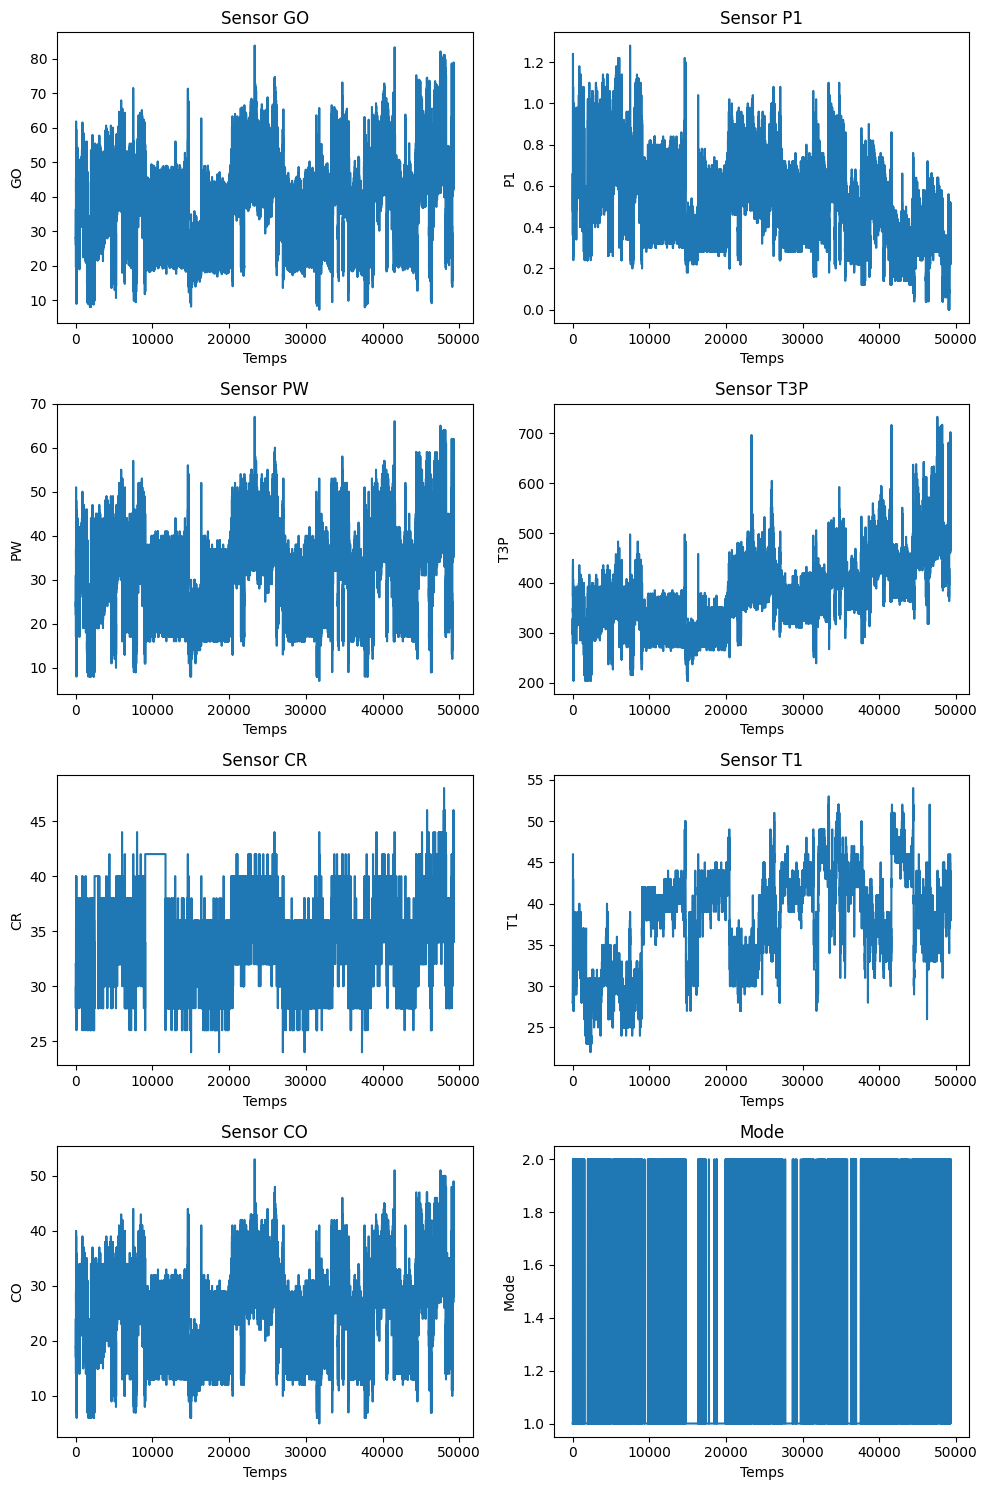

In [ ]:

data_visualisation(Sensor_GO,Sensor_P1,Sensor_PW,Sensor_T3P,Sensor_CR,Sensor_T1,Mode,Sensor_CO)

Nous pouvons voir que pour T3P, la tendance de la courbe, lors du passage en mode dégradé se démarque très fortement de celle des autres variables. C'est la raison pour laquelle nous l'avons chosi comme indicateur de santé.

In [ ]:
corr_matrix(Sensor_T3P,Mode,Sensor_CO,Sensor_CR,Sensor_T1,Sensor_GO,Sensor_P1,Sensor_PW,'T3P')

           T3P      Mode        CO        CR        T1        GO        P1  \
T3P   1.000000  0.712075  0.851312  0.545344  0.281041  0.853627  0.343538   
Mode  0.712075  1.000000  0.780240  0.563029  0.012093  0.785259  0.578773   
CO    0.851312  0.780240  1.000000  0.698423  0.093685  0.997951  0.745298   
CR    0.545344  0.563029  0.698423  1.000000  0.013931  0.705382  0.551731   
T1    0.281041  0.012093  0.093685  0.013931  1.000000  0.092663 -0.091036   
GO    0.853627  0.785259  0.997951  0.705382  0.092663  1.000000  0.742580   
P1    0.343538  0.578773  0.745298  0.551731 -0.091036  0.742580  1.000000   
PW    0.849833  0.779068  0.998401  0.703527  0.093776  0.998855  0.745869   

            PW  
T3P   0.849833  
Mode  0.779068  
CO    0.998401  
CR    0.703527  
T1    0.093776  
GO    0.998855  
P1    0.745869  
PW    1.000000  


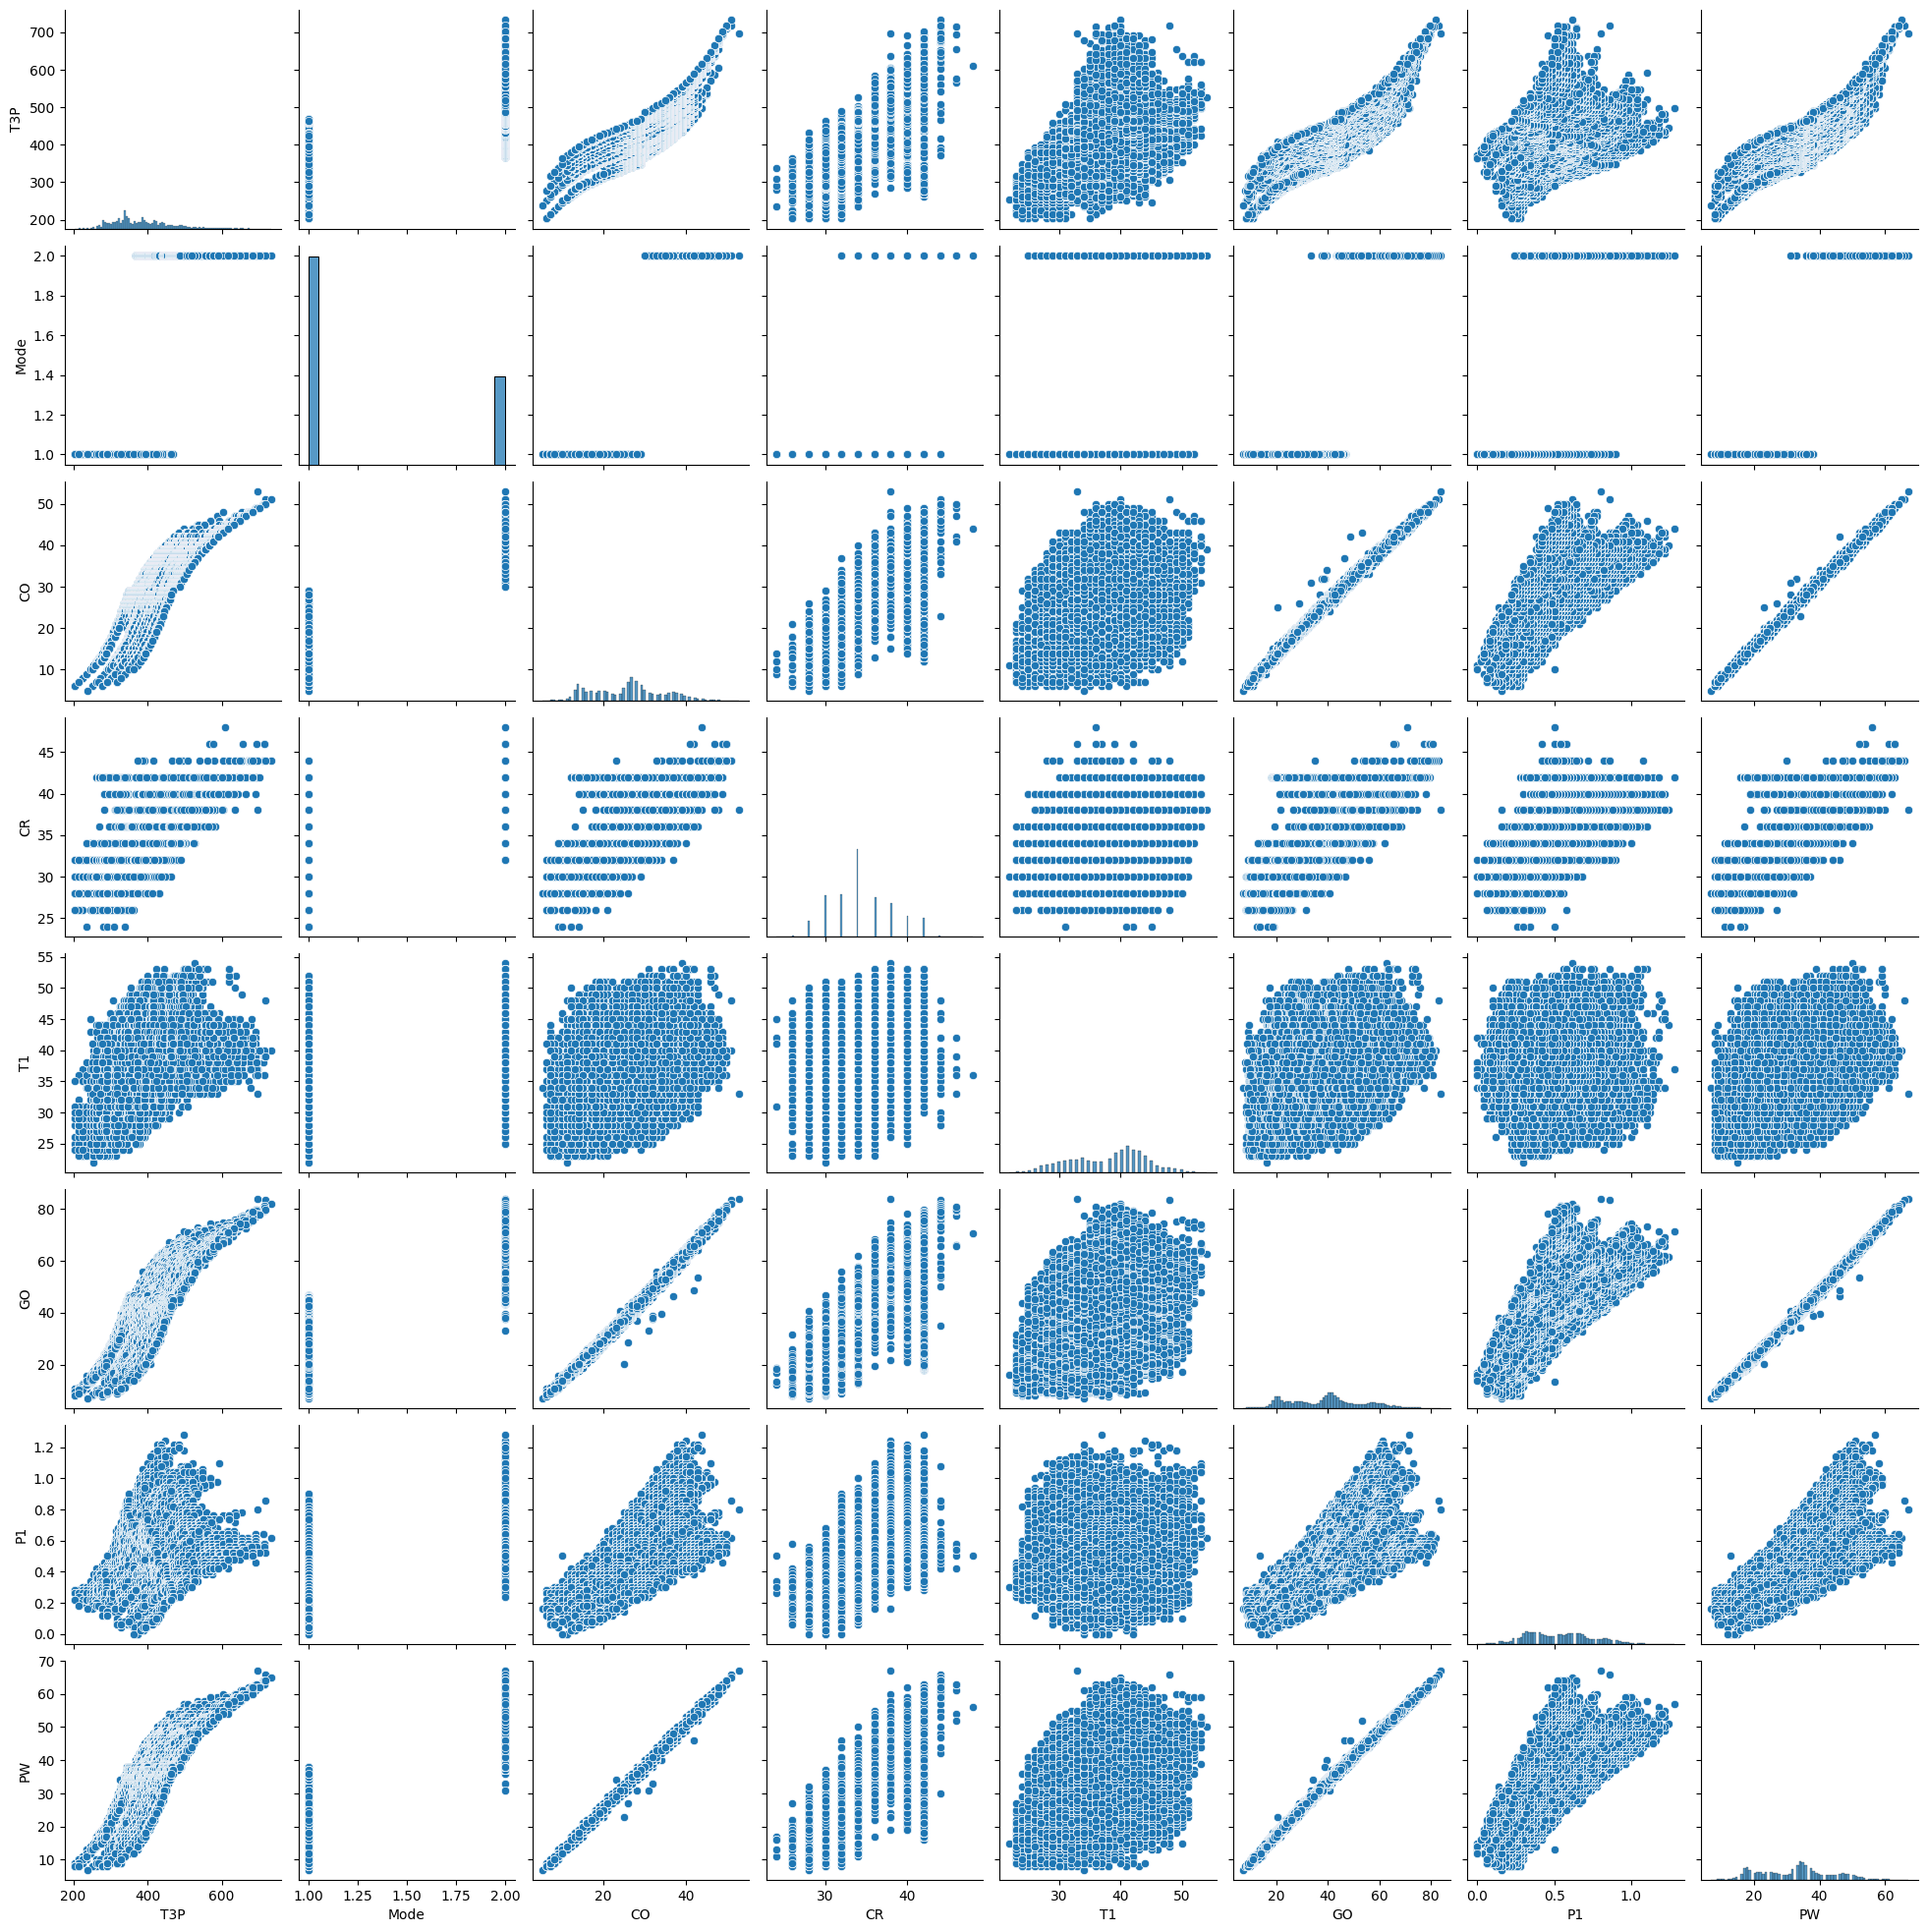

In [26]:
plotpair(Sensor_T3P,Mode,Sensor_CO,Sensor_CR,Sensor_T1,Sensor_GO,Sensor_P1,Sensor_PW)

In [21]:
from sklearn.feature_selection import SequentialFeatureSelector
from progvar import X,Y
sfs = SequentialFeatureSelector(estimator=LinearSVR(dual="auto"),n_features_to_select=2,direction='forward',scoring='r2',n_jobs=-1)
sfs.fit(X,Y)
print(sfs.get_support())

[ True  True False False False False False]


Nous choisissons les facteurs d'influence les plus corrélés à l'indicateur de santé T3P et moins corrélés entre eux à savoir Mo et Co.
Nous cherchons ensuite le meilleur modèle qui modélise la relation T3P = f(Mo,Co)

#### 3. Détermination de la période dégradée et non dégradée 


Période sans dégradation et avec dégradation :

In [19]:
T1,TF=give_degradation(M)
print(f"[0,{T1}],[{T1},{TF}]")


[0,16213],[16213,49277]


#### 4. Détermination du modèle, apprentissage en mode non dégradé et prédiction en mode non dégradé




Les critères  pour les différents modèle en mode non dégradé:

In [20]:
modelfit = test_without_degradation(Sensor_T3P,Mode,Sensor_CO,T1,TF,StandardScaler())

effectue la prediction en mode non dégradé
modèle linéaire:
constante : [329.2968828]
coefs : [ 5.97363484 34.31638199]
coefficient de détermination : 0.4764544082518376
rmse : 464.896837812571
modèle non linéaire:
rmse : 351.32577548196696
coefficient de détermination : 0.6043529530410697
Apprentissage avec modèle de perceptron multicouche pour régression
rmse : 493.2600372963531
coefficient de détermination : 0.4445130680450998
Apprentissage avec arbre de décision
rmse : 256.11555941528763
coefficient de détermination : 0.7115743511164776


Nous avons testé plusieurs modèles pour modéliser la relation entre l'indicateur de santé T3P et les entrées MO et CO en mode non dégradé : les modèles SVR avec plusieurs kernel linéaires et non linéaires, les modèles de perceptrons multicouches et d'arbre de décision pour les regressions. Nous avons constaté que le meilleur modèle pour notre jeu de données est le DecisionTreeRegressor qui nous donne un bon coefficient de détermination de 0.71. Nous sommes passés de 0.44 comme coefficient de détermination avec le perceptron multicouche pour la regression à  0.47 pour le SVR à noyau linéaire à 0.60 pour le SVR à noyau gaussien à finalement 0.71 pour l'arbre de décision de régression. 

#### 6. Prédiction en mode dégradé et calcul du résidu 

Courbe de résidu sur l'intervalle [T1+70%(Tfin-T1), Tfin] du mode dégradé :

moyenne des résidus 52.36993883104811


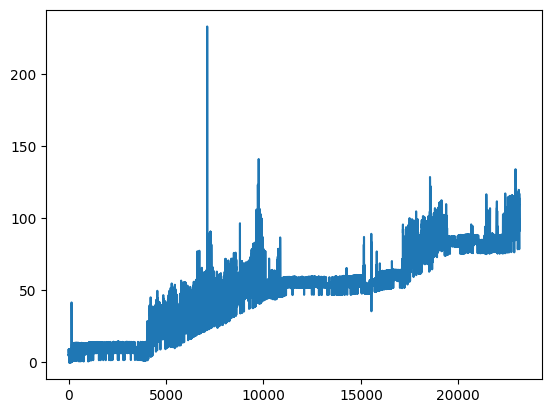

In [27]:
Residu=test_with_degradation(Sensor_T3P,Mode,Sensor_CO,T1,TF,modelfit,StandardScaler())
plt.plot(Residu)
mean = sum(Residu) / len(Residu)
print(f"moyenne des résidus {mean}")
plt.show()

Nous remarquons qu'en moyenne le résidu vaut 52>0, ce qui signifie que le modèle utilisé en mode non dégradé ne prédit pas parfaitement la sortie en mode dégradé. 

## Amélioration des résultats

Au départ, nous avons utilisé la fonction Standardscaler de scikit-learn pour normaliser les données. Cette fonction centre et réduit toutes les variables en mettant leur écart type à 1 et leur moyenne à 0. En testant la fonction MinMaxscaler qui normalise les variables en les ramenant dans l'intervalle [0,1], nous obtenons de meilleurs résultats pour les deux métriques de d'évaluation des modèles : coefficient de détermination et erreur quadratique moyenne. 
Voici les résultats pour chaque modèle en mode non dégradé.

In [21]:
modelfitm = test_without_degradation(Sensor_T3P,Mode,Sensor_CO,T1,TF,MinMaxScaler())

effectue la prediction en mode non dégradé
modèle linéaire:
constante : [241.22431034]
coefs : [ 14.33840172 182.80782299]
coefficient de détermination : 0.9814650996976025
rmse : 16.45857911052899
modèle non linéaire:
rmse : 5.90021432118581
coefficient de détermination : 0.9933554480328137
Apprentissage avec modèle de perceptron multicouche pour régression
rmse : 18.282143235854257
coefficient de détermination : 0.9794114850428411
Apprentissage avec arbre de décision
rmse : 0.47884038849357724
coefficient de détermination : 0.9994607518181317


Cette fois avec la normalisation des variables à l'aide de la fonction MinMaxScaler, nous obtenons comme coefficients de détermination :
* SVR avec kernel linéaire : 0.9814650996976025.
* SVR avec kernel non linéaire gaussien : 0.9933554480328137
* Perceptron multicouches pour regression :  0.9794114850428411
* Arbre de décision pour regression : 0.9994607518181317
Nous remarquons l'arbre de regression reste le modèle avec le coefficient de détermination le plus élevé et l'erreur quadratique moyenne la plus faible. C'est donc le modèle le plus adapté pour notre jeu de données.

La nouvelle courbe de résidu obtenue est la suivante

37.01511820513991


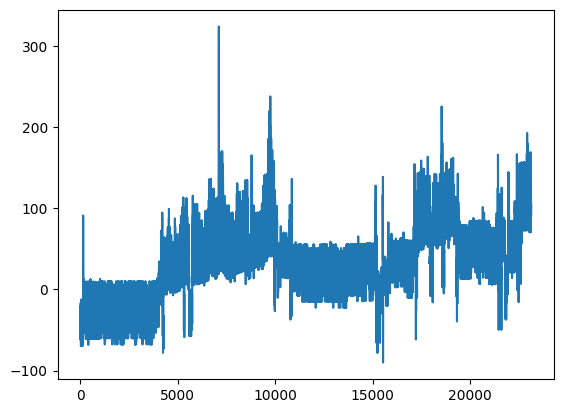

In [25]:
Residu=test_with_degradation(Sensor_T3P,Mode,Sensor_CO,T1,TF,modelfit,MinMaxScaler())
plt.plot(Residu)
mean = sum(Residu) / len(Residu)
print(mean)
plt.show()

Cette fois, le résidu moyen vaut 37 ce qui est inférieur au résidu moyen obtenu avec le modèle utilisant la fonction Standardscaler ce qui signifie ce que le modèle utilisant la fonction MinMaxscaler en mode non dégradé prédit mieux la sortie en mode dégradé.  

## Conclusion:
Finalement, grâce aux différents tests que nous avons effectués sur les prétraitements (normalisation) et la modélisation des données, nous avons réussi à construire un modèle de prédiction pour notre indicateur de santé T3P avec un coefficient de détermination de 0.9994607518181317 sur les données de test. Nous avons également pu calculer et afficher le résidu qui lui est associé. Une piste qu'il reste à explorer pour notre travail est la modélisation du résidu dans le but de prédire la durée de vie résiduelle.